**Table of contents**<a id='toc0_'></a>    
- [Computing the transition in the HANC model - manually!](#toc1_)    
  - [Previous code to compute the stationary equilibrium](#toc1_1_)    
  - [Partial equilibrium transition](#toc1_2_)    
  - [Transitions in general equilibrium](#toc1_3_)    
    - [A shooting algorithm](#toc1_3_1_)    
    - [A 'manual Jacobian' approach](#toc1_3_2_)    
    - [The Fake-News algorithm](#toc1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [60]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

# <a id='toc1_'></a>[Computing the transition in the HANC model - manually!](#toc0_)

In [61]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.9498866874132476
        self.sigma = 1.0
        
        # production
        self.alpha = 1/3
        self.delta = 0.1/3
        self.Gamma = 1.0
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.95
        self.sigma_psi = 0.30*(1.0-self.rho_z**2.0)**0.5
        self.Nz = 7
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

## <a id='toc1_1_'></a>[Previous code to compute the stationary equilibrium](#toc0_)

In [62]:
""" 
Household backward step
"""

def egm_ss(r, w, par, max_iter = 50_000, tol = 1e-12, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            return c, a, Va_new

        Va = Va_new
    
    

def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute m_endo = c(a',z) + a'
        m_endo = c_endo + a_grid # current consumption + end-of-period assets
        
        # iii. interpolation to fixed grid
        m = (1+r)*a_grid + w*z_grid[i_z] # exogenous grid of coh
        interp_1d_vec(m_endo,a_grid,m,a[i_z]) # fill up the array a[i_z]
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = m-a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


In [63]:
""" 
Household forward step
"""

def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

@nb.njit
def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend

def distribution_ss(a, par, tol=1E-10):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new



In [64]:
""" 
Household block steady-state
"""

def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    D = distribution_ss(a, par)
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 

In [65]:
def find_ss_beta(beta, par):
    par.beta = beta
    r = 0.05
    w = 1-par.alpha
    K = 4 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 
par.beta = brentq(find_ss_beta, 0.9, 0.952, args=(par,))

r_ss = 0.05 
Y_ss = 1 
K_ss = 4 
par.alpha = 1/3 
par.Gamma = Y_ss /(K_ss**par.alpha)
par.delta = par.alpha * par.Gamma * K_ss**(par.alpha-1) - r_ss
w_ss = (1-par.alpha) * Y_ss
A_ss, C_ss, D_init, a_ss, c_ss, Va_term = household_ss(r_ss, w_ss, par) 

-3.9999999999999987
18.850971301144178
-3.9999999999999964
-3.975423715491448
-3.690302699991704
-2.7649965573647464
-0.8924888421928925
1.3487170555343484
-0.21485529404579662
0.009983083845258811
-0.0004332611687845045
-8.180241333199945e-07
2.204991744747531e-11
-1.881705014028512e-09


## <a id='toc1_2_'></a>[Partial equilibrium transition](#toc0_)

In [66]:
T = 1000
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
w_vec[0] = w_vec[0] * 1.01

a_trans = np.zeros((T, par.Nz, par.Na))
c_trans = np.zeros((T, par.Nz, par.Na))
Va_trans = Va_term.copy()
for t in reversed(range(T)):
    c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r_vec[t], w_vec[t], Va_trans)

In [67]:
D_trans = np.zeros((T, par.Nz, par.Na))
D_trans[0] = D_init 

for t in range(T-1):
    a_i, a_pi = get_lottery(a_trans[t], par.a_grid)
    D_trans[t+1] = forward_iteration(D_trans[t], par.z_trans, a_i, a_pi)

In [68]:
@nb.njit
def forward_iteration_trans(D_init, z_trans, a_i, a_pi, T):
    Nz, Na = D_init.shape
    D = np.zeros((T, Nz, Na))
    D[0] = D_init
    for t in range(T-1):
        D[t+1] = forward_iteration(D[t], z_trans, a_i[t], a_pi[t])
    return D

In [69]:
A_trans = np.sum(D_trans * a_trans, axis = (1,2))
C_trans = np.sum(D_trans * c_trans, axis = (1,2))

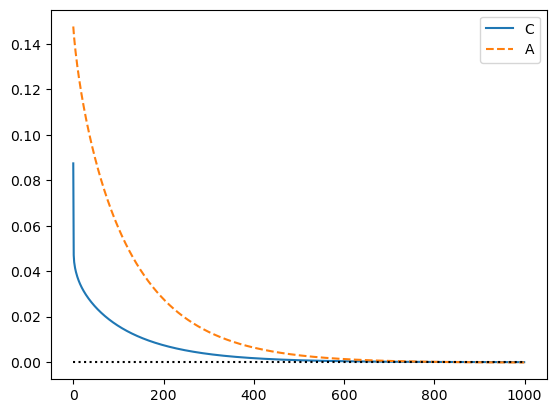

In [70]:
plt.plot(100*(C_trans-C_ss)/C_ss, label = 'C')
plt.plot(100*(A_trans-A_ss)/A_ss, label = 'A', linestyle = '--')
plt.plot(np.zeros_like(A_trans), linestyle = ':', color = 'black')
plt.legend()
plt.show()

In [71]:
def get_impulse_response(Va_term, D_init, r_vec, w_vec, par):
    # backward step
    a_trans = np.zeros((T, par.Nz, par.Na))
    c_trans = np.zeros((T, par.Nz, par.Na))
    Va_trans = Va_term.copy()
    for t in reversed(range(T)):
        c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r_vec[t], w_vec[t], Va_trans)

    # forward step
    D_trans = np.zeros((T, par.Nz, par.Na))
    D_trans[0] = D_init
    a_i, a_pi = get_lottery(a_trans, par.a_grid)

    D_trans = forward_iteration_trans(D_init, par.z_trans, a_i, a_pi, T)    
    A_trans = np.sum(D_trans * a_trans, axis = (1,2))
    C_trans = np.sum(D_trans * c_trans, axis = (1,2))

    return C_trans, A_trans, D_trans, c_trans, a_trans

## <a id='toc1_3_'></a>[Transitions in general equilibrium](#toc0_)

In [72]:
def firm(K, Gamma, K_ss, par): 
    K_vec = K.copy()
    K_vec[1:] = K[:-1]
    K_vec[0] = K_ss 

    I = K - (1-par.delta) * K_vec

    r = par.alpha * Gamma * K_vec**(par.alpha-1) - par.delta
    Y = Gamma * K_vec**par.alpha
    w = (1-par.alpha) * Y
    return r, w, Y, I

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_10255/2315011876.py:6: SyntaxWarning: invalid escape sequence '\G'
  plt.title("Percentage change in $\Gamma$")


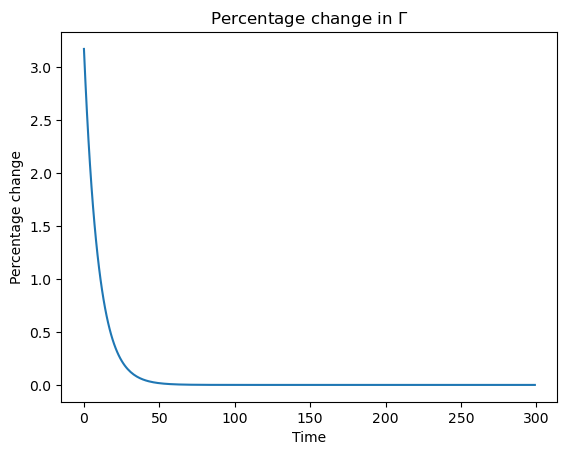

In [73]:
T = 300
sigma = 0.02
rho = 0.9
Gamma_shock = par.Gamma + sigma * rho ** np.arange(T)
plt.plot((Gamma_shock-par.Gamma)/par.Gamma*100)
plt.title("Percentage change in $\Gamma$")
plt.xlabel("Time")
plt.ylabel("Percentage change")
plt.show()

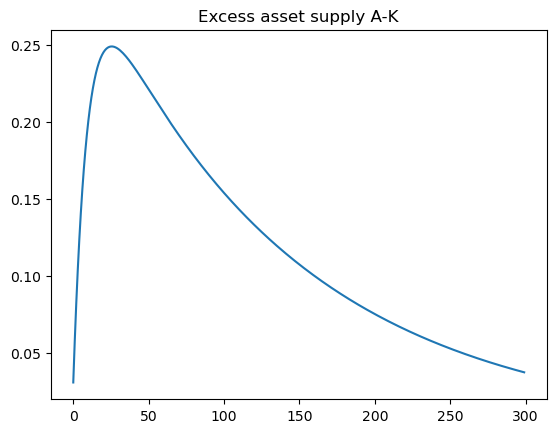

In [74]:
K_trans = np.ones((T)) * K_ss
r_trans, w_trans, Y_trans, I_trans, = firm(K_trans, Gamma_shock, K_ss, par)

C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
asset_market = A_trans - K_trans
plt.plot(asset_market)
plt.title('Excess asset supply A-K')
plt.show()

### <a id='toc1_3_1_'></a>[A shooting algorithm](#toc0_)

In [75]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans = (1-adj) * K_trans + adj * A_trans


0.2488828875265936
0.1544943001810002
0.11629314131076463
0.08184290442863595
0.06443946153436109
0.051816277920314846
0.0423122323040781
0.034847185049770246
0.029040840964727366
0.024323109654705632
0.020455934113409846
0.017354366032796165
0.014760106333592482
0.012581361042418138
0.010745178918251774
0.009229979494804752
0.007951138989366058
0.006858772014134651
0.0059237831000693575
0.00512202947662832
0.004433383394306212
0.0038409957360610036
0.003340317031400808
0.002911902116687237
0.0025402880493787805
0.0022176122384838237
0.0019371627275708292
0.0016931974367153657
0.0014807945231325448
0.001295727651144496
0.0011343618698154145
0.0009935661025926024
0.0008706395629598518
0.0007632495918521442
0.0006696332767219815
0.0005896637532867288
0.0005194271352246815
0.0004577104231531237
0.00040345635743399555
0.0003557426768070471
0.0003137642479718039
0.00027681767335252516
0.0002442880099655653
0.00021563729363638373
0.0001903946103061216
0.00016814749722282585
0.000148534485817

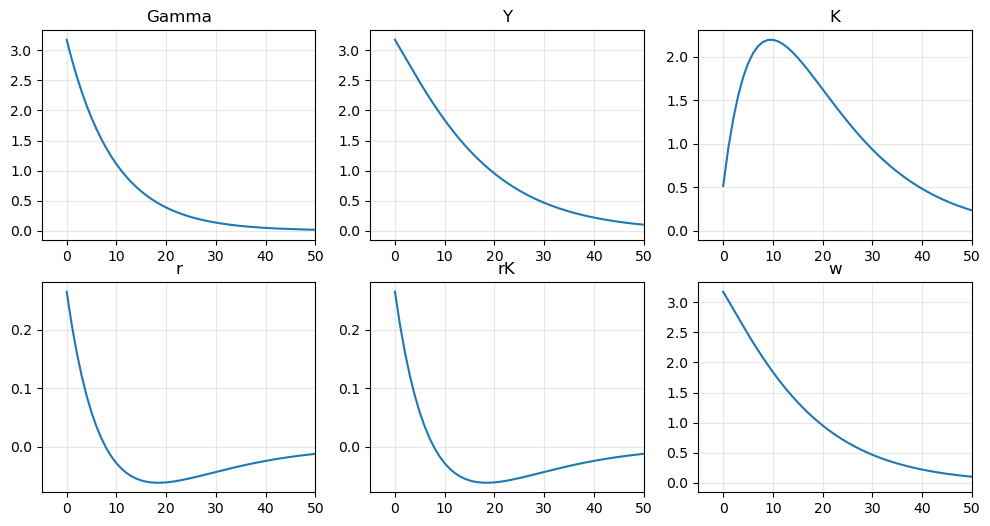

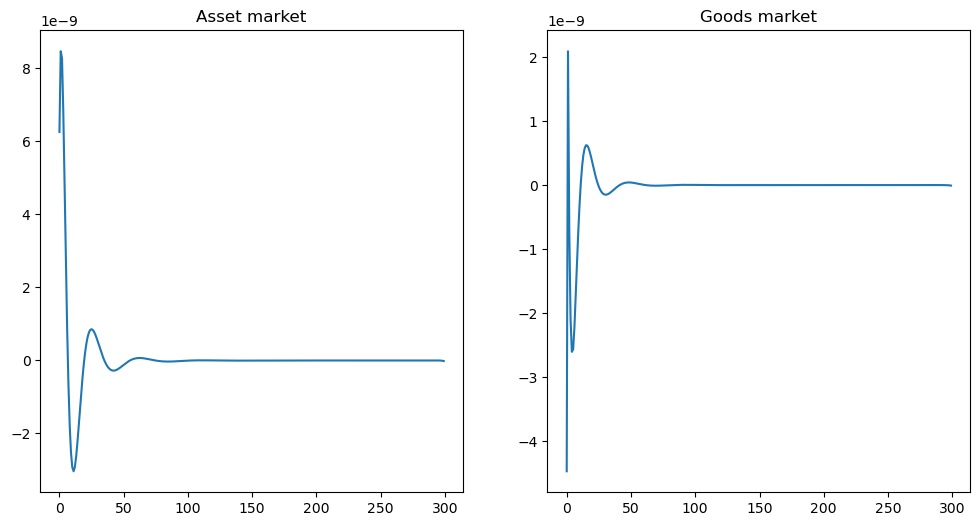

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 50)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

### <a id='toc1_3_2_'></a>[A 'manual Jacobian' approach](#toc0_)

In [77]:
T = 300
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss

_, A_no_shock, _, _, a_0 = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
a_ss = a_0[0] # to avoid numerical errors, run a blank transition and update steady state policy functions. This is for numerical precision only, not necessary per se.

In [78]:
h = 1e-4
J_w = np.zeros((T, T))

for s in range(T):
    r_vec = np.ones((T)) * r_ss
    w_vec = np.ones((T)) * w_ss
    
    w_vec[s] = w_ss + h

    C_trans, A_trans, _, _, _ = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
    J_w[:,s] = (A_trans - A_no_shock) / h

In [79]:
J_r = np.zeros((T, T))

for s in range(T):
    r_vec = np.ones((T)) * r_ss
    w_vec = np.ones((T)) * w_ss

    r_vec[s] = r_vec[s] + h

    C_trans, A_trans, _, _, _ = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
    J_r[:,s] = (A_trans - A_no_shock) / h

In [80]:
dw_dK_analytical = (1-par.alpha) * par.alpha * par.Gamma * K_ss**(par.alpha-1)
dr_dK_analytical = par.alpha * par.Gamma * (par.alpha-1) * K_ss**(par.alpha-2)

dw_dK = np.zeros((T, T))
dr_dK = np.zeros((T, T))

dw_dK[1:,:-1] = np.eye(T-1) * dw_dK_analytical
dr_dK[1:,:-1] = np.eye(T-1) * dr_dK_analytical

In [81]:
H_K = J_w @ dw_dK + J_r @ dr_dK - np.eye(T)

In [82]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)


0.2488828875265936
0.004111755894257385
3.980506264689154e-05
1.2075508415421154e-07
1.0458398591595142e-09


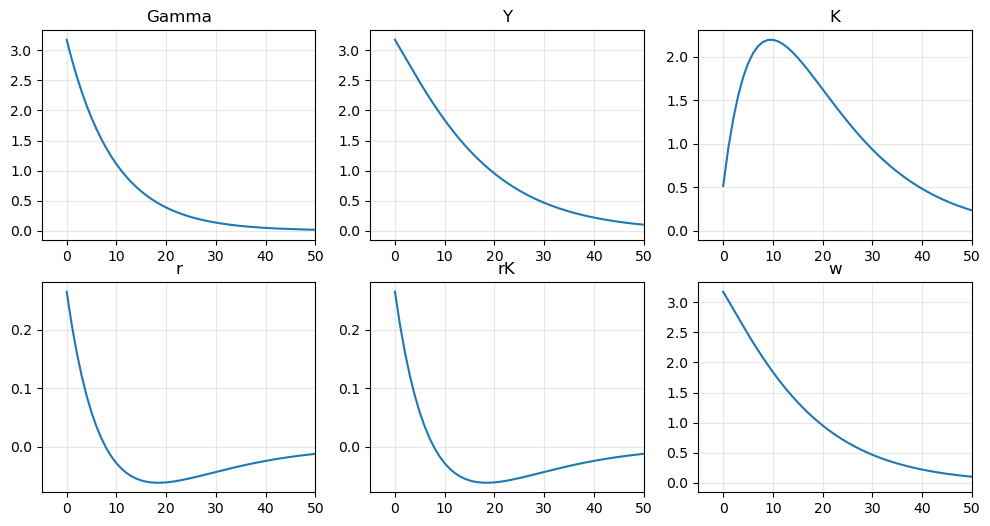

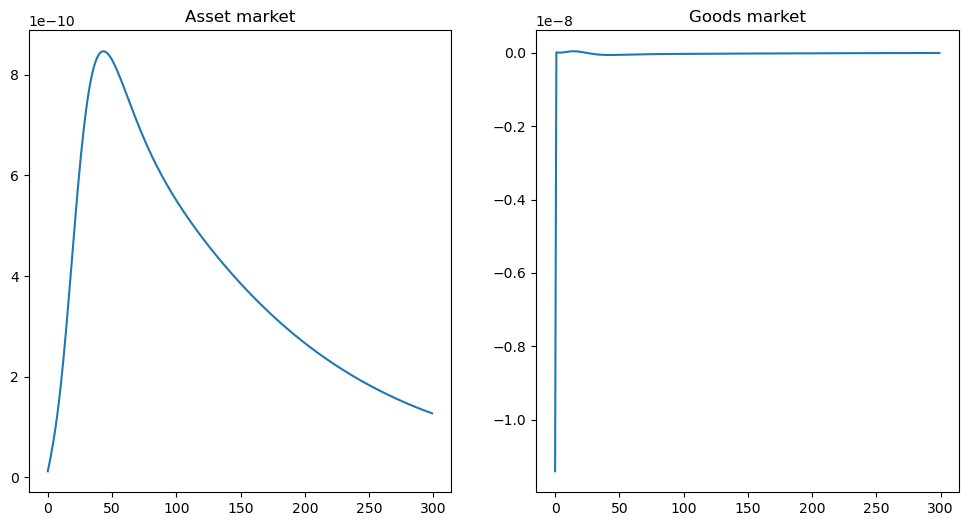

In [83]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 50)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

We can reuse the Jocabian to compute the transitions to a new shock if we want! For example, let's do a huge TFP shock.

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_10255/1266288242.py:6: SyntaxWarning: invalid escape sequence '\G'
  plt.title("Percentage change in $\Gamma$")


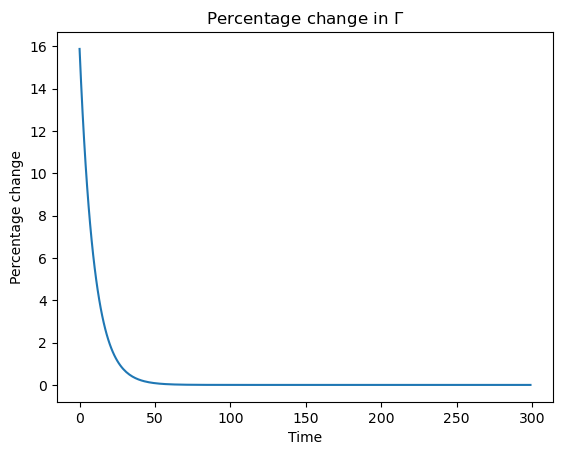

1.3419288849705708
0.10210792724121553
0.005661540452294389
9.347531911707563e-05
3.1984963033693248e-06
1.2544420258109312e-07
1.6137384761805151e-09


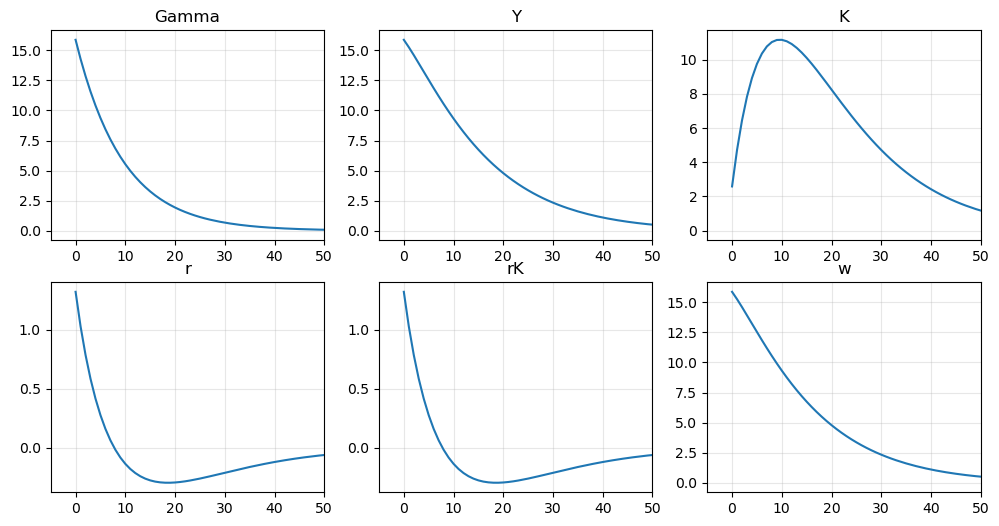

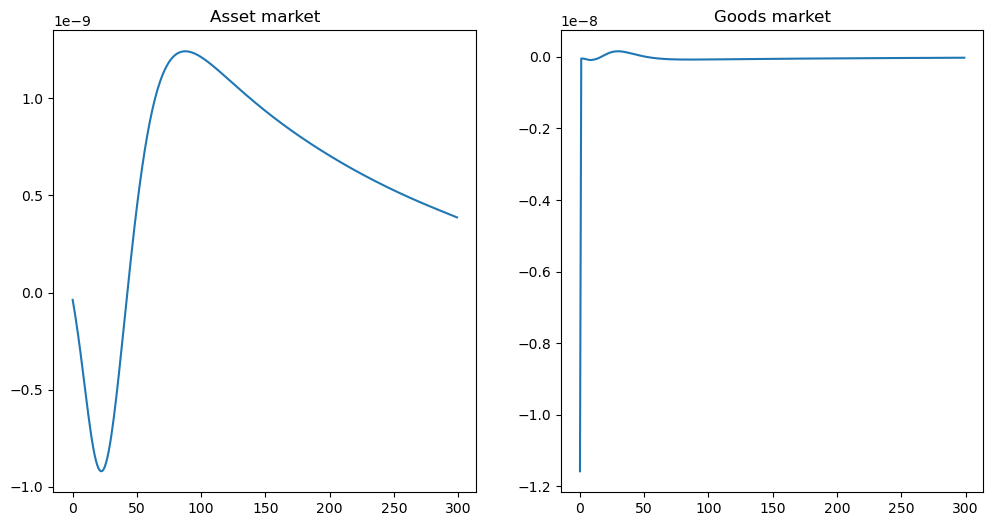

In [84]:
T = 300
sigma = 0.1
rho = 0.9
Gamma_shock = par.Gamma + sigma * rho ** np.arange(T)
plt.plot((Gamma_shock-par.Gamma)/par.Gamma*100)
plt.title("Percentage change in $\Gamma$")
plt.xlabel("Time")
plt.ylabel("Percentage change")
plt.show()

K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 50)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

Solved in one second!

### <a id='toc1_3_3_'></a>[The Fake-News algorithm](#toc0_)

We managed to speed up the time to compute a transition significantly, but computing the Jacobian is still costly. Luckily, we can do much faster using the fake-news algorithm of Auclert et al (2021). 

Main insight: for every column $s$ of the Jacobian, all policy functions for $t>s$ are the steady state policy functions. 

Why? What matters is the distance to the shock! This means we can compute one transition for a shock at $s=T$, and back out the policy functions for every column $s$ by reordering them appropriately. 

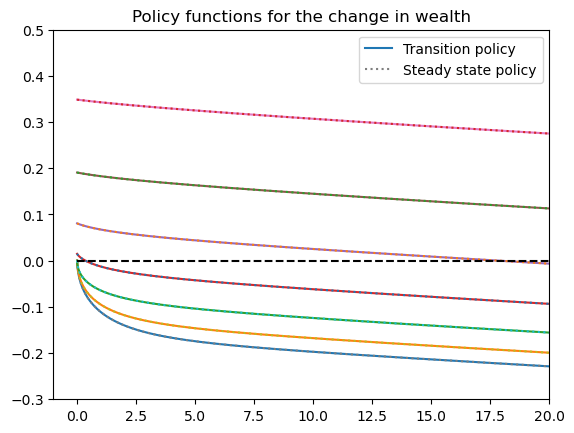

In [85]:
h = 1e-4
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss

s = 5
w_vec[s] = w_vec[s] + h

_, _, _, _, a_trans = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

lines1 = plt.plot(par.a_grid, (a_trans[s+1]-par.a_grid[np.newaxis,:]).T)
lines2 = plt.plot(par.a_grid, (a_ss-par.a_grid[np.newaxis,:]).T, linestyle = ':')
plt.plot(np.zeros_like(par.a_grid), linestyle = '--', color = 'black')
lines1[0].set_label('Transition policy')
lines2[0].set_label('Steady state policy')
plt.xlim(-1, 20)
plt.ylim(-0.3, 0.5)
plt.legend()
plt.title("Policy functions for the change in wealth")
plt.show()

In [93]:
J_w_fake_news = np.zeros((T, T))

# First, compute the impulse response for a shock on w at the last period
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
w_vec[-1] = w_ss + h

_, _, _, _, a_trans_last = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

# Discretize the policies
a_i_last, a_pi_last = get_lottery(a_trans_last, par.a_grid)
a_i_ss,   a_pi_ss   = get_lottery(np.broadcast_to(a_ss,(T,)+a_ss.shape), par.a_grid)

# Rearange them and do a forward path for each s 
for s in range(T):
    a_path = np.broadcast_to(a_ss,(T,)+a_ss.shape).copy()
    a_path[:s+1] = a_trans_last[T-1-s:]  # distance invariance

    ai = a_i_ss.copy()
    ap = a_pi_ss.copy()
    ai[:s+1] = a_i_last[T-1-s:]
    ap[:s+1] = a_pi_last[T-1-s:]

    D_trans = forward_iteration_trans(D_init, par.z_trans, ai, ap, T)
    A_trans = np.sum(D_trans * a_path, axis=(1,2))
    J_w_fake_news[:, s] = (A_trans - A_no_shock) / h

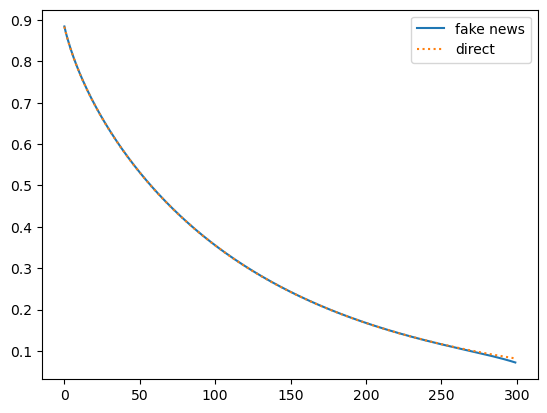

In [87]:
s = 0
plt.plot(J_w_fake_news[:,s], label = 'fake news')
plt.plot(J_w[:,s], linestyle = ':', label = 'direct')
plt.legend()
plt.show()

We can use the same code to compute the Jacobian with respect to $r$ using the fake-news algorithm again.

In [94]:
J_r_fake_news = np.zeros((T, T))

# First, compute the impulse response for a shock on w at the last period
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
r_vec[-1] = r_ss + h

_, _, _, _, a_trans_last = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

# Discretize the policies
a_i_last, a_pi_last = get_lottery(a_trans_last, par.a_grid)
a_i_ss,   a_pi_ss   = get_lottery(np.broadcast_to(a_ss,(T,)+a_ss.shape), par.a_grid)

# Rearange them and do a forward path for each s 
for s in range(T):
    a_path = np.broadcast_to(a_ss,(T,)+a_ss.shape).copy()
    a_path[:s+1] = a_trans_last[T-1-s:]  # distance invariance

    ai = a_i_ss.copy()
    ap = a_pi_ss.copy()
    ai[:s+1] = a_i_last[T-1-s:]
    ap[:s+1] = a_pi_last[T-1-s:]

    D_trans = forward_iteration_trans(D_init, par.z_trans, ai, ap, T)
    A_trans = np.sum(D_trans * a_path, axis=(1,2))
    J_r_fake_news[:, s] = (A_trans - A_no_shock) / h

## Linear transitions

So far, we have computed MIT (perfect-foresight) shocks. At the steady-state, households believe there is no chance such a shock happens. Once the shock happens at $t=0$, they have perfect foresight over the path of $r$ and $w$, and believe no shock will happen again (strong assumption).

Another way it to take a linear 

In [95]:
dr_dZ_analytical = par.alpha * K_ss**(par.alpha-1)
dw_dZ_analytical = (1-par.alpha) * K_ss**par.alpha

dr_dZ = np.eye(T) * dr_dZ_analytical
dw_dZ = np.eye(T) * dw_dZ_analytical

In [ ]:
T = 300
sigma = 0.02
rho = 0.9
dGamma = sigma * rho ** np.arange(T) 

H_K = J_w_fake_news @ dw_dK + J_r_fake_news @ dr_dK - np.eye(T)
H_Z = J_w_fake_news @ dw_dZ + J_r_fake_news @ dr_dZ  
G = -np.linalg.solve(H_K, H_Z) 
dK = G @ dGamma

In [97]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, (par.Gamma +dGamma), K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)


0.2488828875265936
0.004709224328193429
3.3429839145782125e-05
1.11524275148156e-07
9.993401661745338e-10


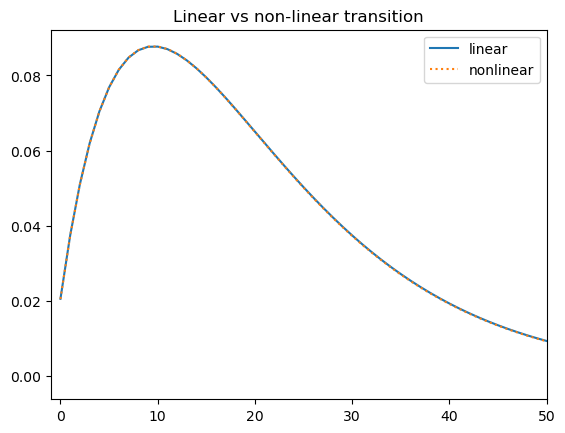

In [101]:
plt.plot(dK, label = 'linear')
plt.plot(K_trans - K_ss, label = 'nonlinear', linestyle = ':')
plt.xlim(-1, 50)
plt.legend()
plt.title('Linear vs non-linear transition')
plt.show()

It works! But what happens if we take a big shock?

2.9336070063048716
0.40065192760023116
0.050466583106771434
0.001735577389183618
0.00010182003113090587
7.6073835941770085e-06
1.8823302916359808e-07
2.0013728452283885e-08
1.2242526992167768e-09


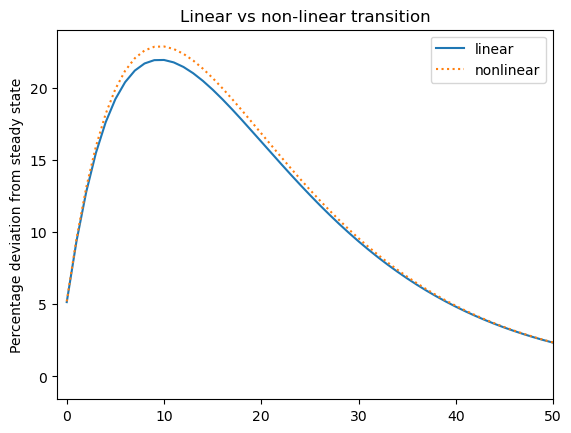

In [104]:
T = 300
sigma = 0.2
rho = 0.9
dGamma = sigma * rho ** np.arange(T) 

H_K = J_w_fake_news @ dw_dK + J_r_fake_news @ dr_dK - np.eye(T)
H_Z = J_w_fake_news @ dw_dZ + J_r_fake_news @ dr_dZ  
G = -np.linalg.solve(H_K, H_Z) 
dK = G @ dGamma

K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, (par.Gamma +dGamma), K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)

plt.plot(dK/K_ss * 100, label = 'linear')
plt.plot((K_trans - K_ss)/K_ss * 100, label = 'nonlinear', linestyle = ':')
plt.xlim(-1, 50)
plt.legend()
plt.ylabel('Percentage deviation from steady state')
plt.title('Linear vs non-linear transition')
plt.show()

We find some differences between the linear and non-linear show up because of non-linearities.